# Libererías necesarias

In [1]:
import pandas as pd
from sentence_transformers import SentenceTransformer, util
import fasttext
from sklearn.metrics.pairwise import cosine_similarity
import plotly.express as px
from sklearn.decomposition import PCA
import numpy as np
import sys
import umap
import altair as alt
import matplotlib.pyplot as plt
import seaborn as sns

Primero importamos el dataset que hemos limpiado con la función anteriormente creada

In [2]:
with open("../data/cleaned_data/cleaned_arab_quran.txt", encoding="utf-8") as f:
    lines = f.readlines()

df = pd.DataFrame(lines, columns=["text"])
df["text"] = df["text"].str.strip()

df.head()

,text
0,1|1|بسم الله الرحمن الرحيم
1,1|2|الحمد لله رب العالمين
2,1|3|الرحمن الرحيم
3,1|4|مالك يوم الدين
4,1|5|اياك نعبد واياك نستعين


In [3]:
with open("../data/cleaned_data/cleaned_english_quran.txt", encoding="utf-8") as f:
    lines = f.readlines()

df = pd.DataFrame(lines, columns=["text"])
df["text"] = df["text"].str.strip()

df.head()

,text
0,in the name of allah the entirely merciful the...
1,all praise is due to allah lord of the worlds
2,the entirely merciful the especially merciful
3,sovereign of the day of recompense
4,it is you we worship and you we ask for help


# Creación de los modelos

Ahora vamos a usar varios modelos diferentes para comparar los resultados, usaremos el concepto "الجنة" (paraíso) para ambas.

In [4]:
concept = "الجنة"

## Sentence-Transformer Árabe

Importamos el sentence-transformer que vamos a usar para ambos idiomas, ya que éste es multilingüe.

In [5]:
model = SentenceTransformer('distiluse-base-multilingual-cased-v2')

df_st = pd.DataFrame(lines, columns=["text"])
df_st["text"] = df_st["text"].str.strip()
df_st = df_st[df_st["text"].str.contains(r"[\u0600-\u06FF]")]
df_st["arab_embeddings"] = df_st["text"].apply(lambda x: model.encode(x, convert_to_tensor=True))

concept_emb = model.encode(concept, convert_to_tensor=True)

df_st["cos_similarity"] = df_st["arab_embeddings"].apply(lambda x: util.pytorch_cos_sim(x, concept_emb).item())

df_st_sorted = df_st.sort_values(by="cos_similarity", ascending=False)
print("\nTop 10 Sentence-Transformers:")
print(df_st_sorted[["text", "cos_similarity"]].head(10))

# model.save("../src/modelos/sentence_transformers_arabe_busqueda_semantica")


Top 10 Sentence-Transformers:
Empty DataFrame
Columns: [text, cos_similarity]
Index: []


## FastText Árabe

Ahora probaremos el mismo proceso con el modelo recomendado por nuestro profesor: 'fastText'. Como se verá en los hiperparámetros, las sub palabras hacen referencia a N-gramas de caracteres, es decir, caracteres de entre 3 a 6 letras. (hay que tener en cuenta que a diferencia de sentence-transformer, fast text devuelve vectores Numpy, y no vectores PyTorch)

In [6]:
ft = fasttext.train_unsupervised(
    input="../data/cleaned_data/cleaned_arab_quran.txt",
    model="skipgram",
    dim=300,
    epoch=10,
    minn=3,  # sub palabras mínimas
    maxn=6   # sub palabras máximas
)

# ft.save_model("../src/modelos/fasttext_arabic_busqueda_semantica.bin")

df_ft = pd.DataFrame(lines, columns=["text"])
df_ft["text"] = df_ft["text"].str.strip()
df_ft = df_ft[df_ft["text"].str.contains(r"[\u0600-\u06FF]")]

df_ft["arab_embeddings"] = df_ft["text"].apply(lambda x: ft.get_sentence_vector(x))

concept_emb = ft.get_sentence_vector(concept)

df_ft["cos_similarity"] = df_ft["arab_embeddings"].apply(
    lambda x: cosine_similarity([x], [concept_emb])[0][0]
)

df_ft_sorted = df_ft.sort_values(by="cos_similarity", ascending=False)
print("Top 10 FastText:")
print(df_ft_sorted[["text", "cos_similarity"]].head(10))

Read 0M words
Number of words:  2016
Number of labels: 0
Progress:  99.2% words/sec/thread:   66203 lr:  0.000411 avg.loss:  2.528098 ETA:   0h 0m 0s

Top 10 FastText:
Empty DataFrame
Columns: [text, cos_similarity]
Index: []


Progress: 100.0% words/sec/thread:   63440 lr:  0.000000 avg.loss:  2.524803 ETA:   0h 0m 0s


Repetiremos el mismo proceso para el Corán en inglés:

In [7]:
concept = "Paradise" # el mismo que antes, pero ahora en inglés

## Sentence-transformer en inglés

In [8]:
model = SentenceTransformer('distiluse-base-multilingual-cased-v2')

df_st = pd.DataFrame(lines, columns=["text"])
df_st["text"] = df_st["text"].str.strip()
df_st = df_st[df_st["text"].str.len() > 0]
df_st["eng_embeddings"] = df_st["text"].apply(lambda x: model.encode(x, convert_to_tensor=True))

concept_emb = model.encode(concept, convert_to_tensor=True)

df_st["cos_similarity"] = df_st["eng_embeddings"].apply(lambda x: util.pytorch_cos_sim(x, concept_emb).item())

df_st_sorted = df_st.sort_values(by="cos_similarity", ascending=False)
print("\nTop 10 Sentence-Transformers:")
print(df_st_sorted[["text", "cos_similarity"]].head(10))

# model.save("../src/modelos/sentence_transformers_ingles_busqueda_semantica")


Top 10 Sentence-Transformers:
                                             text  cos_similarity
6022                        and enter my paradise        0.519508
6232                           the god of mankind        0.502047
6222                     allah the eternal refuge        0.500632
5812            and when paradise is brought near        0.445605
4681            by the heaven containing pathways        0.439895
2348                                        ta ha        0.434508
5752      then indeed paradise will be his refuge        0.432990
4739                and by the heaven raised high        0.432732
5820  obeyed there in the heavens and trustworthy        0.430074
5630                and when the heaven is opened        0.409571


## FastText en inglés

In [9]:
ft = fasttext.train_unsupervised(
    input="../data/cleaned_data/cleaned_english_quran.txt",
    model="skipgram",
    dim=300,
    epoch=10,
    minn=3,  # sub palabras mínimas
    maxn=6   # sub palabras máximas
)

# ft.save_model("../src/modelos/fasttext_english_busqueda_seamantica.bin")

df_ft = pd.DataFrame(lines, columns=["text"])
df_ft["text"] = df_ft["text"].str.strip()

df_ft["eng_embeddings"] = df_ft["text"].apply(lambda x: ft.get_sentence_vector(x))

concept_emb = ft.get_sentence_vector(concept)

df_ft["cos_similarity"] = df_ft["eng_embeddings"].apply(
    lambda x: cosine_similarity([x], [concept_emb])[0][0]
)

df_ft_sorted = df_ft.sort_values(by="cos_similarity", ascending=False)
print("Top 10 FastText:")
print(df_ft_sorted[["text", "cos_similarity"]].head(10))

Read 0M words
Number of words:  1924
Number of labels: 0
Progress: 100.0% words/sec/thread:   80807 lr:  0.000000 avg.loss:  2.546826 ETA:   0h 0m 0sm 0s


Top 10 FastText:
                                                   text  cos_similarity
4019  gardens of perpetual residence whose doors wil...        0.835028
6022                              and enter my paradise        0.826547
2683  who will inherit al firdaus they will abide th...        0.820795
549   but those who believe and do righteous deeds w...        0.819825
1772  and those who believed and did righteous deeds...        0.814822
1931  gardens of perpetual residence which they will...        0.812882
2423  gardens of perpetual residence beneath which r...        0.807993
2617  indeed allah will admit those who believe and ...        0.804273
1323  allah has prepared for them gardens beneath wh...        0.798804
3397  and those who have believed and done righteous...        0.796206


# Resultados después de la comparación:
Después de tratar con ambos idiomas y los 2 modelos, y ver que ambos devuelven pasajes similares, concluimos con que hay una diferencia abismal en cuanto a la similitud de coseno. Ya que el modelo 'fastText' obtiene mejores resultados. Por esa razón y por la recomendación del profesor, hemos decidido quedarnos con este modelo para más adelante.

# Carga de los Modelos

Sentence-transformer árabe:

In [12]:
# sentence_transformer_arabe = SentenceTransformer('distiluse-base-multilingual-cased-v2')

Fasttext árabe:

In [13]:
# fasttext_arabe = fasttext.load_model("../src/modelos/fasttext_arabic_busqueda_semantica.bin")

Sentence-transformer inglés:

In [14]:
# sentence_transformer_ingles = SentenceTransformer('distiluse-base-multilingual-cased-v2')

Fasttext inglés:

In [15]:
# fasttext_ingles = fasttext.load_model("../src/modelos/fasttext_english_busqueda_seamantica.bin")

# Visualización de los resultados:
Después de concluir que el modelo 'FastText' rinde mucho mejor para la búsqueda semántica, vamos a visualizar los resultados obtenidos con éste. Para esto, vamos a recolectar los 5 pasajes más similares y los 5 más disimilares del Corán introducido un concepto arbitrario y luego hacer plot 3d para visualizar el espacio de los embeddings. Así podríamos apreciar que los vectores son contrarios en cierta manera. Para esto, utilizaremos PCA para reducir la dimensionalidad para una visualización mejor.

In [16]:
# Empezaremos en inglés
concepto = "Paradise"
emb_conepto = ft.get_sentence_vector(concepto)

df_ft_nonempty = df_ft[df_ft["text"].notna() & (df_ft["text"].str.strip() != "")]
# Top 5 embeddings más similares
top_5_similares = df_ft.nlargest(5, 'cos_similarity')[["text", "eng_embeddings", "cos_similarity"]]
# Top 5 embeddings más disimilares
top_5_disimilares = df_ft_nonempty.nsmallest(5, 'cos_similarity')[["text", "eng_embeddings", "cos_similarity"]]

top_5_similares["group"] = "Similar"
top_5_disimilares["group"] = "Diferentes"

df_concat = pd.concat([top_5_similares, top_5_disimilares], ignore_index=True)
df_concat = pd.DataFrame(df_concat)

df_concat["textos"] = df_concat["text"].fillna("").astype(str)
df_concat["tooltip"] = df_concat["textos"].apply(lambda x: x if x.strip() != "" else "No hay texto")
embedding_matrix = np.vstack(df_concat["eng_embeddings"].values)

pca = PCA(n_components=3)
embeddings_3d = pca.fit_transform(embedding_matrix)
df_concat[["x", "y", "z"]] = embeddings_3d

Esta línea es necesaria para evitar problemas de dependencias de librerías:

In [17]:
import sys
if "narwhals" in sys.modules:
    del sys.modules["narwhals"]

Visualización 3D de los embeddings

In [18]:
fig = px.scatter_3d(
    df_concat,
    x="x",
    y="y",
    z="z",
    color="group",
    hover_name="textos",  
    size_max=10,
    title=f"Visualización en 3 dimensiones de los 5 embeddings más similares y disimilares del concepto: '{concepto}'"
)

fig.update_layout(
    scene=dict(
        xaxis_title='X',
        yaxis_title='Y',
        zaxis_title='Z'
    ),
    legend_title_text='Grupo'
)

fig.show()


Visualización 2D de los embeddings

In [19]:
textos = df_concat["text"].tolist()
embeddings_2d = df_concat["eng_embeddings"].tolist()

reducer = umap.UMAP(n_neighbors=5) # Número de vecinos = 5 para los 5 más similares y 5 más disimilares
umap_embeddings = reducer.fit_transform(embeddings_2d)

df_umap = pd.DataFrame({"textos": textos,
                        "x": umap_embeddings[:, 0],
                        "y": umap_embeddings[:, 1],
                        "group": df_concat["group"]})

plot_umap = (
    alt.Chart(df_umap).mark_circle(size=100).encode(x="x", y="y", color="group", tooltip=["textos", "group"])
    .properties(title=f"Visualización con UMAP de los 5 embeddings más similares y disimilares a '{concepto}'")
)

plot_umap.interactive()

alt.Chart(...)

Heatmap de los pasajes

Text(0.5, 1.0, "Matriz de similitud de coseno entre los 5 embeddings de los pasajes más similares y disimilares con el concepto: 'Paradise'")

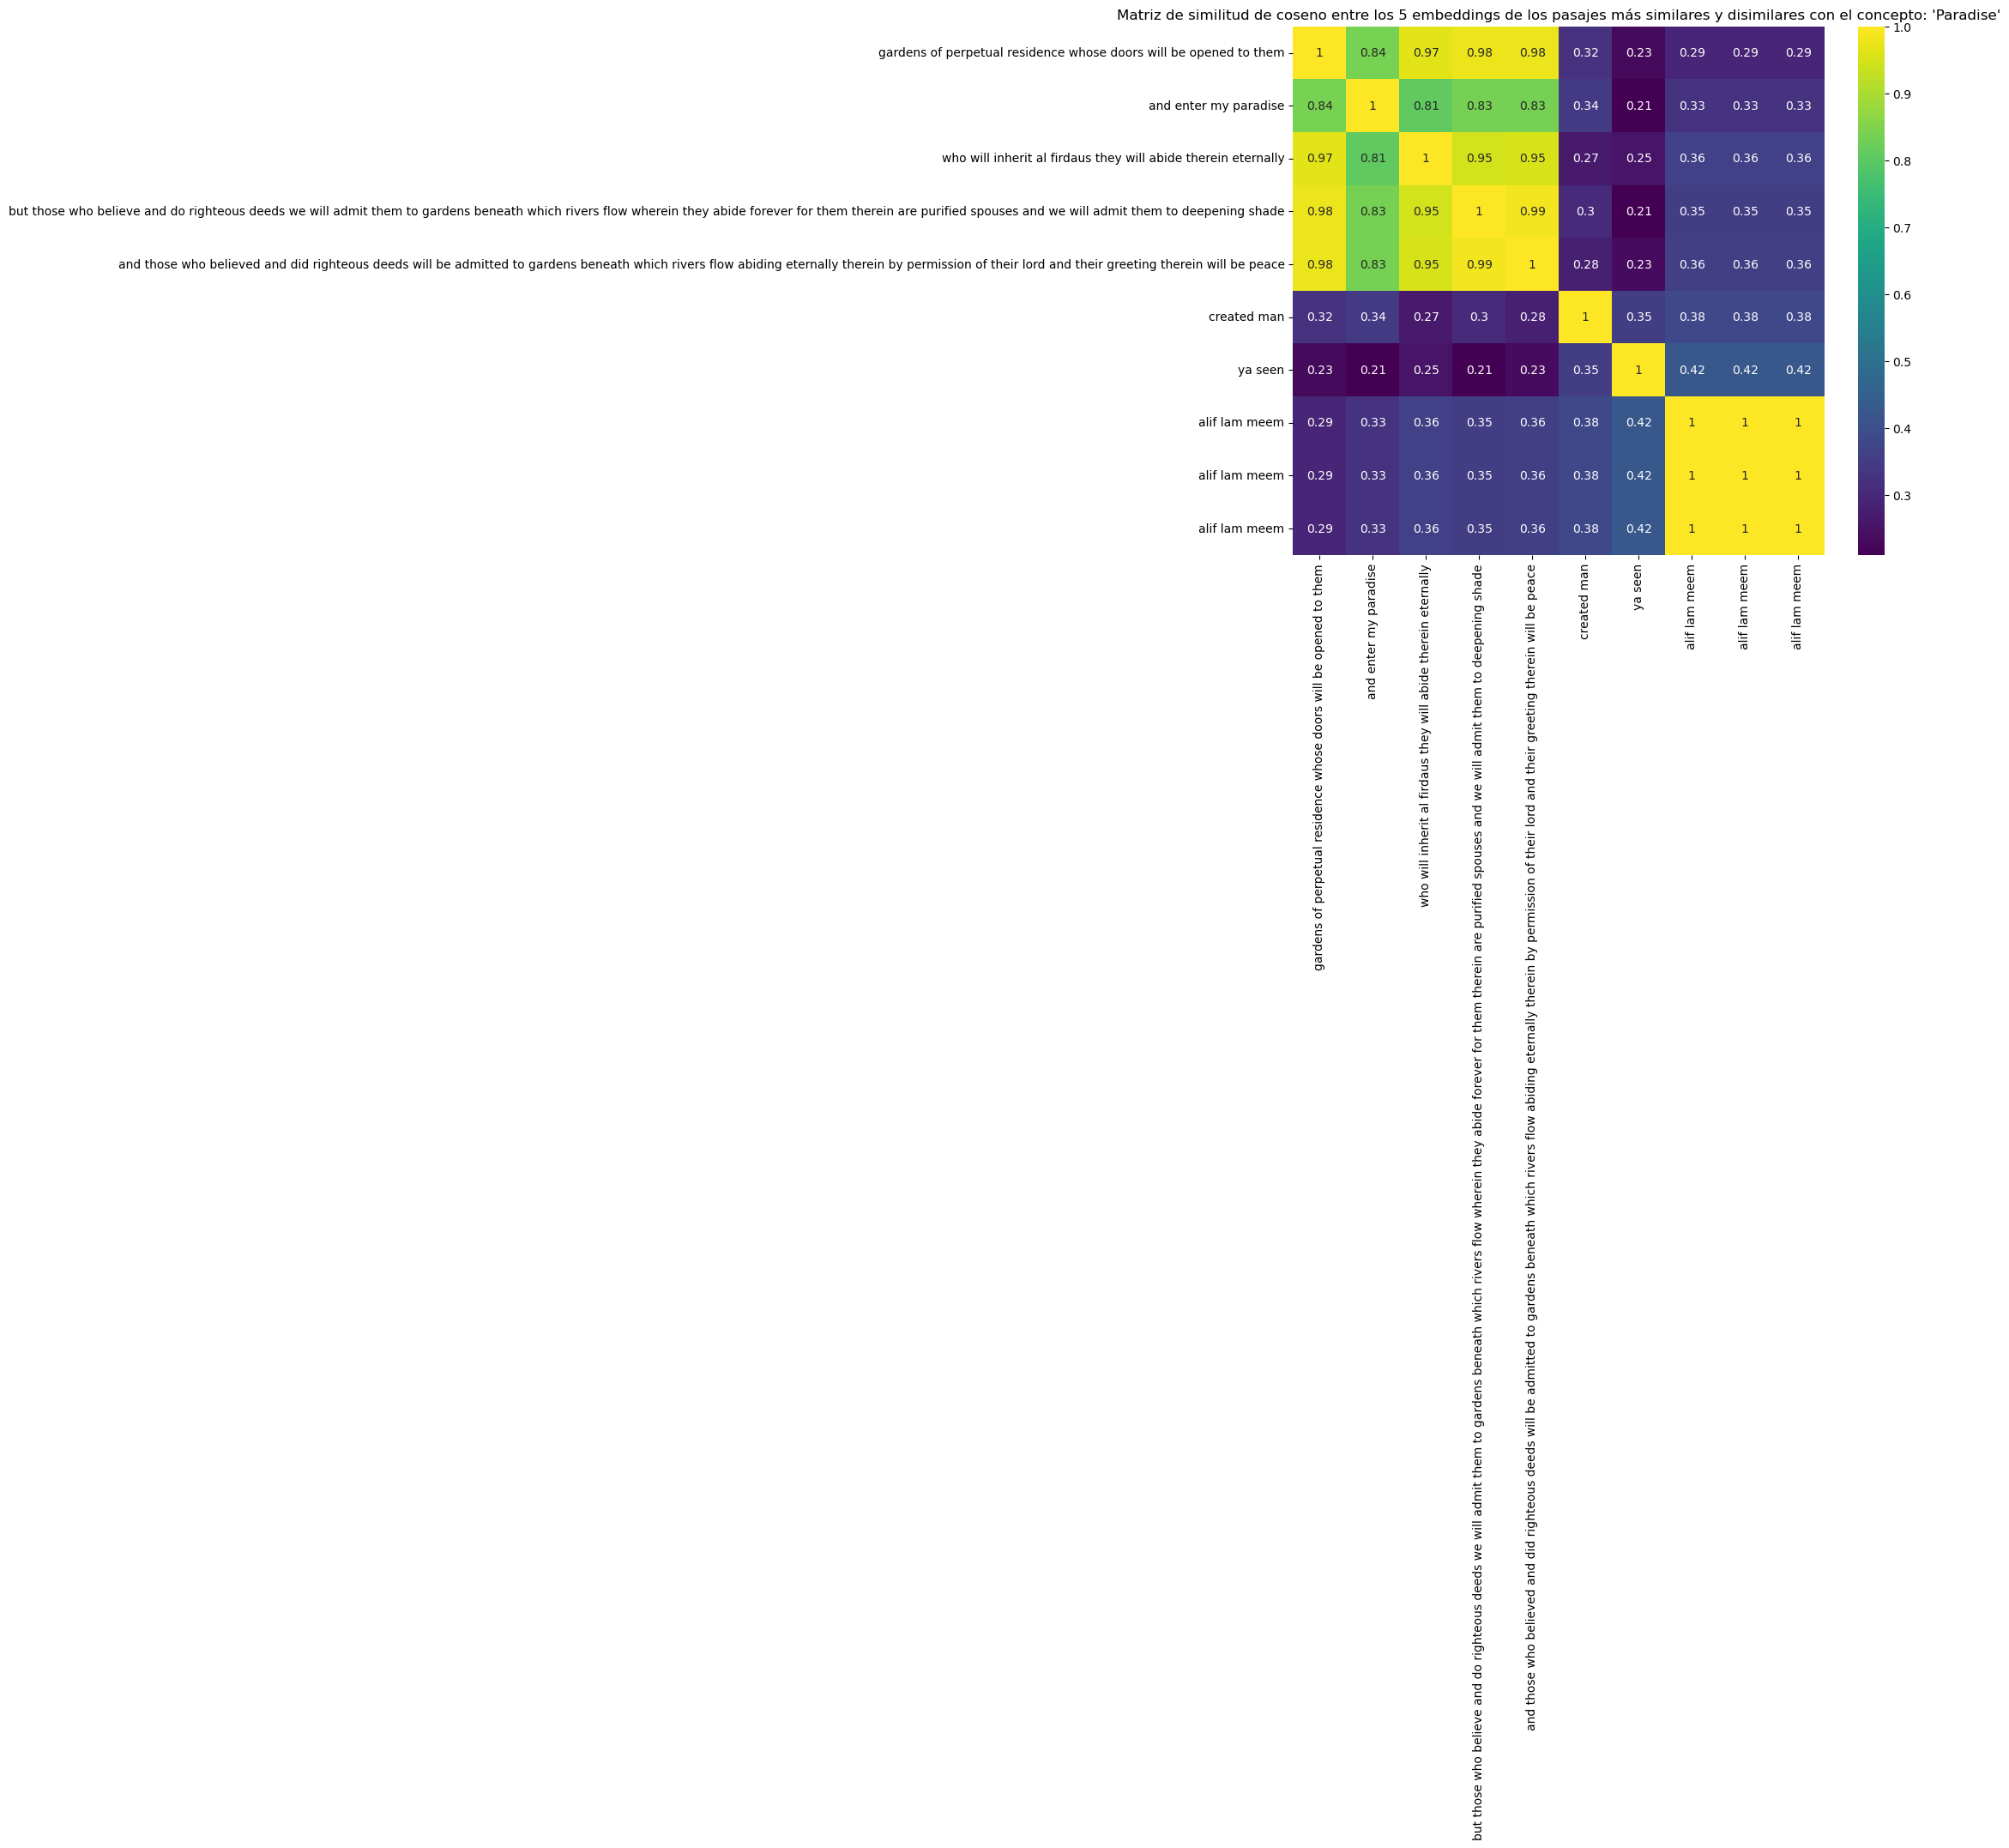

In [20]:
similarity_matrix = np.vstack(df_concat["eng_embeddings"].values)
similarity_matrix = cosine_similarity(similarity_matrix)
textos = df_concat["text"].tolist()

plt.figure(figsize=(10, 8))
sns.heatmap(similarity_matrix, xticklabels=textos, yticklabels=textos, cmap='viridis', annot=True)
plt.title(f"Matriz de similitud de coseno entre los 5 embeddings de los pasajes más similares y disimilares con el concepto: '{concepto}'")